## Toy example: Inferring the mean of Gaussians

#### comparing the multi-round SNPE approach against our new incremental approach.

Goal of this little toy example is to show that provided our parameters are independent of each other, we need less simulations to derive a good approximation of our parameters.

In [12]:
import sys
sys.path.append('../code/')

import utils
from utils.helpers import get_time
from utils import inference

from utils.sbi_modulated_functions import Combined


from utils.helpers import get_time

from utils.simulation_wrapper import SimulationWrapper


# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import SNPE_C

import sbi


In [13]:
print(sbi.__version__)

0.17.2


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def Gaussian(thetas, normal_noise=0.1):
    
    gauss_list = []
    
    for theta in thetas:
    
        mu, sigma = theta, normal_noise # mean and standard deviation

        s = np.random.normal(mu, sigma, 1)
        
        gauss_list.append(s[0])
        
    gauss_obs = torch.tensor(gauss_list)
    
    return gauss_obs
    



In [3]:
true_thetas = torch.tensor([[3, 0.5, 6, 20, 10, 90, 55, 27]])



gauss = Gaussian(true_thetas[0], 0.5)
    

    

In [4]:
print(gauss)

tensor([ 2.6909,  0.4003,  6.0626, 19.5947,  9.2927, 89.3749, 54.8735, 27.2959],
       dtype=torch.float64)


In [5]:
prior_max = [100] * 8
prior_min = [0] * 8

print(prior_max)

[100, 100, 100, 100, 100, 100, 100, 100]


### Starting with the Multi-round SNPE approach

In [64]:
from sbi import utils as utils

num_simulations = 100

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)
inf = SNPE_C(prior, density_estimator="mdn")
simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

proposal = prior

for i in range(8):

    theta, x = simulate_for_sbi(
        simulator_stats,
        proposal=proposal,
        num_simulations=num_simulations,
        num_workers=8,
    )
    
    #x = sum_stats(x_without)


    inf = inf.append_simulations(theta, x)
    density_estimator = inf.train()

    posterior = inf.build_posterior(density_estimator)
    
    obs_real = Gaussian(true_thetas[0])
    
    print(obs_real)

    
    proposal = posterior.set_default_x(obs_real)

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Neural network successfully converged after 115 epochs.
tensor([ 2.8727,  0.4985,  6.0386, 20.0575, 10.0006, 90.0550, 54.9757, 27.0132],
       dtype=torch.float64)


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Neural network successfully converged after 189 epochs.
tensor([ 2.9429,  0.5453,  6.0027, 19.7676,  9.9593, 89.7941, 54.8638, 27.0155],
       dtype=torch.float64)


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Neural network successfully converged after 50 epochs.
tensor([ 2.9975,  0.4351,  6.1478, 19.8991,  9.8997, 89.9881, 54.8677, 27.0094],
       dtype=torch.float64)


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Neural network successfully converged after 55 epochs.
tensor([ 2.8845,  0.4608,  6.0399, 19.9828, 10.0637, 89.9387, 54.9326, 26.9069],
       dtype=torch.float64)


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Neural network successfully converged after 42 epochs.
tensor([ 3.0203,  0.5965,  6.0689, 20.0062,  9.8791, 90.1291, 54.8188, 27.0893],
       dtype=torch.float64)


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Neural network successfully converged after 36 epochs.
tensor([ 2.8648,  0.6022,  6.1168, 19.7772, 10.0633, 89.8659, 54.9029, 27.0660],
       dtype=torch.float64)


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Neural network successfully converged after 89 epochs.
tensor([ 3.0947,  0.5596,  5.9243, 20.1275,  9.8198, 90.0856, 54.8842, 26.8215],
       dtype=torch.float64)


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Neural network successfully converged after 110 epochs.
tensor([ 3.0509,  0.4492,  6.0174, 20.0416,  9.9395, 89.9016, 54.9981, 26.9959],
       dtype=torch.float64)


In [65]:
num_samples = 10000

samples = posterior.sample((num_samples,), x=obs_real)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [66]:
list_min = torch.min(samples, 0)[0]
list_max = torch.max(samples, 0)[0]

print(list_min)

print(list_max)

diff = torch.abs(list_max - list_min) * 0.05

print(diff)

list_min = list(list_min - diff)
list_max = list(list_max + diff)

limits = [list(tup) for tup in zip(list_min, list_max)]

tensor([4.3603e-04, 1.6188e-04, 4.4255e-03, 1.6863e+01, 5.0206e+00, 8.5619e+01,
        4.7648e+01, 2.5147e+01])
tensor([ 7.4089,  5.4325, 13.6890, 23.3434, 15.2682, 94.4536, 61.0516, 31.6522])
tensor([0.3704, 0.2716, 0.6842, 0.3240, 0.5124, 0.4417, 0.6702, 0.3253])


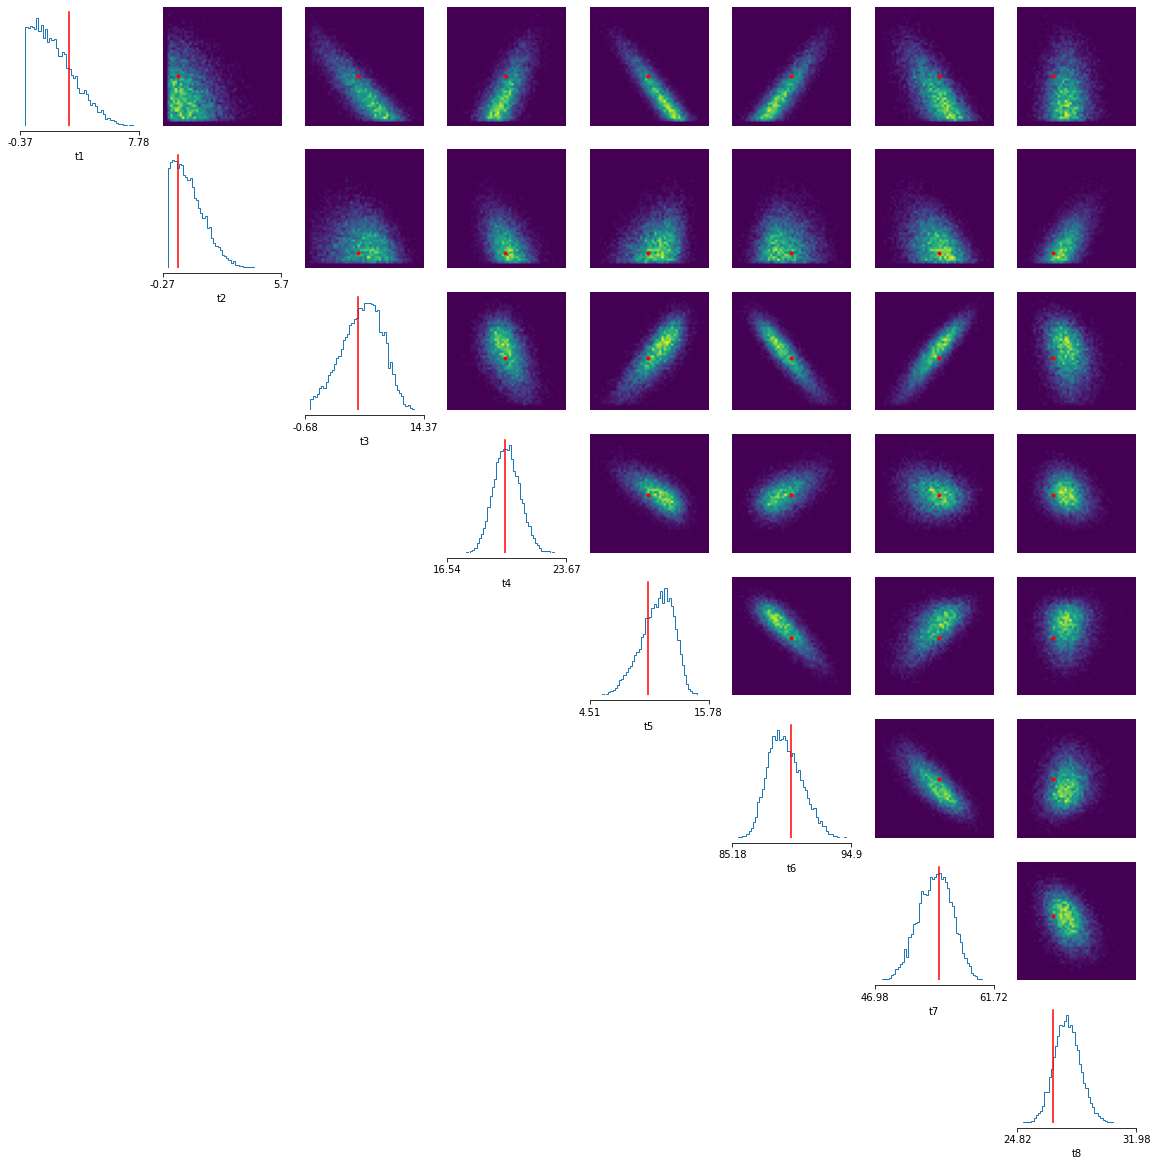

In [67]:
#limits = [list(tup) for tup in zip(prior_min, prior_max)]
true_thetas = torch.tensor([[3, 0.5, 6, 20, 10, 90, 55, 27]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8']

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    ticks=limits,
    figsize=(20, 20),
    points=true_thetas,
    points_offdiag={"markersize": 6},
    points_colors="r",
    tick_labels=np.round(limits,2),
    labels=parameter_names,
)

### Now we do the same, but with the incremental approach:

In [9]:
import datetime
range_list = [1,2,3,4,5,6,7,8]
num_simulations = 10

true_thetas = torch.tensor([[3, 0.5, 6, 20, 10, 90, 55, 27]])

prior_i = utils.torchutils.BoxUniform(low=prior_min[0:1], high = prior_max[0:1])
inf = SNPE_C(prior_i, density_estimator="mdn")
simulator_stats, prior_i = prepare_for_sbi(Gaussian, prior_i)

obs_real = Gaussian([true_thetas[0, 0]])



for index in range(len(range_list)-1):

    ## i defines number of parameters to be inferred, j indicates how many parameters 
    #to come in the next round
    i = range_list[index]
    j = range_list[index+1]

    print(i, j)


    start_time = datetime.datetime.now()

    theta, x =  simulate_for_sbi(
        simulator_stats,
        proposal=prior_i,
        num_simulations=num_simulations,
        num_workers=8,
        
    )



    inf = inf.append_simulations(theta, x)
    neural_dens = inf.train()

    posterior = inf.build_posterior(neural_dens)
    
    if i < 2:
        obs_real = Gaussian([true_thetas[0, 0:i]])
        
    else:
        obs_real = Gaussian(true_thetas[0, 0:i])



    proposal1 = posterior.set_default_x(obs_real)

    next_prior = utils.torchutils.BoxUniform(low=prior_min[i:j], high=prior_max[i:j])

    combined_prior = Combined(proposal1, next_prior, number_params_1=i)


    ## set inf for next round:
    inf = SNPE_C(combined_prior, density_estimator="mdn")


    ## set combined prior to be the new prior_i:
    prior_i = combined_prior
    
    finish_time = datetime.datetime.now()
    
    diff = finish_time - start_time
    
    print('took ', diff, ' for this step')
    

1 2


Running 10 simulations in 10 batches.:   0%|          | 0/10 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Neural network successfully converged after 398 epochs.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta shape torch.Size([1, 2])
took  0:00:02.521947  for this step
2 3


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

theta shape torch.Size([10, 2])


Running 10 simulations in 10 batches.:   0%|          | 0/10 [00:00<?, ?it/s]

Neural network successfully converged after 171 epochs.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta shape torch.Size([1, 3])
took  0:00:00.954020  for this step
3 4


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

theta shape torch.Size([10, 3])


Running 10 simulations in 10 batches.:   0%|          | 0/10 [00:00<?, ?it/s]

Neural network successfully converged after 121 epochs.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta shape torch.Size([1, 4])
took  0:00:00.709851  for this step
4 5


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

theta shape torch.Size([10, 4])


Running 10 simulations in 10 batches.:   0%|          | 0/10 [00:00<?, ?it/s]

Neural network successfully converged after 28 epochs.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta shape torch.Size([1, 5])
took  0:00:00.357663  for this step
5 6


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

theta shape torch.Size([10, 5])


Running 10 simulations in 10 batches.:   0%|          | 0/10 [00:00<?, ?it/s]

Neural network successfully converged after 21 epochs.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta shape torch.Size([1, 6])
took  0:00:00.257069  for this step
6 7


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

theta shape torch.Size([10, 6])


Running 10 simulations in 10 batches.:   0%|          | 0/10 [00:00<?, ?it/s]

Neural network successfully converged after 76 epochs.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta shape torch.Size([1, 7])
took  0:00:00.625516  for this step
7 8


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

theta shape torch.Size([10, 7])


Running 10 simulations in 10 batches.:   0%|          | 0/10 [00:00<?, ?it/s]

Neural network successfully converged after 83 epochs.


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta shape torch.Size([1, 8])
took  0:00:00.663906  for this step


In [10]:
prior_i.sample((100,)).shape

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

theta shape torch.Size([100, 8])


torch.Size([100, 8])

In [11]:
    
theta, x =  simulate_for_sbi(
    simulator_stats,
    proposal=prior_i,
    num_simulations=num_simulations,
    num_workers=8,

)

inf = inf.append_simulations(theta, x)
neural_dens = inf.train()

posterior = inf.build_posterior(neural_dens) 

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

theta shape torch.Size([10, 8])


Running 10 simulations in 10 batches.:   0%|          | 0/10 [00:00<?, ?it/s]

Neural network successfully converged after 90 epochs.


In [13]:
obs_real = Gaussian(true_thetas[0, :])



posterior.set_default_x(obs_real)

In [15]:
num_samples = 10000


samples = posterior.sample((num_samples,), x=obs_real)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
samples.shape

torch.Size([10000, 8])

In [17]:
list_min = torch.min(samples, 0)[0]
list_max = torch.max(samples, 0)[0]

print(list_min)

print(list_max)

diff = torch.abs(list_max - list_min) * 0.1

print(diff)

list_min = list(list_min - diff)
list_max = list(list_max + diff)

limits = [list(tup) for tup in zip(list_min, list_max)]

tensor([   2.0314,   -8.4027, -104.8420,   -6.8462,  -42.2604, -155.7926,
        -106.3282,  -58.9968])
tensor([  3.6916,  12.1166, 133.5852,  65.4551, 185.4382, 297.8690, 170.9125,
        200.5642])
tensor([ 0.1660,  2.0519, 23.8427,  7.2301, 22.7699, 45.3662, 27.7241, 25.9561])


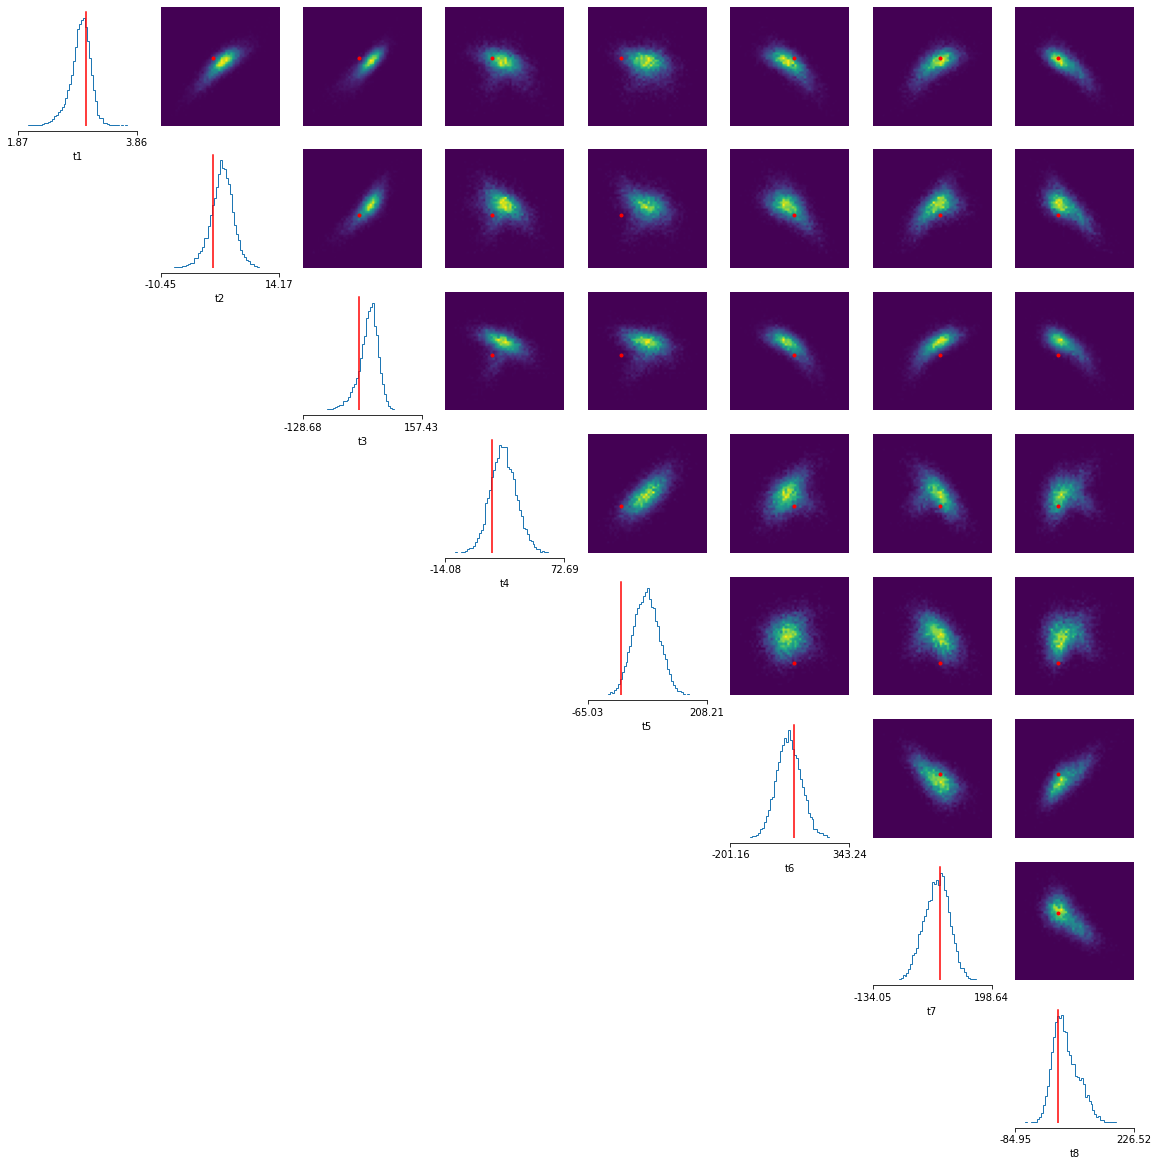

In [18]:
true_thetas = torch.tensor([[3, 0.5, 6, 20, 10, 90, 55, 27]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8']




fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    ticks=np.round(limits, 2),
    figsize=(20, 20),
    points=true_thetas,
    points_offdiag={"markersize": 6},
    points_colors="r",
    tick_labels=np.round(limits,2),
    labels=parameter_names,
)

### Larger comparison with KL-divergence between analytic and inferred posterior

In [19]:
from math import log2

def kl_divergence(p, q):
    return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

In [21]:
### analytic posterior:


analytic_list = []

for theta in true_thetas:
    analytic = torch.distributions.normal.Normal(theta, 0.1)
    analytic_list.append(analytic)




### Calculate posterior for different number of simulations: 1k,  3k, 5k, 10k

### starting with multi-round snpe

In [15]:
true_thetas = torch.tensor([[3.0, 6, 20.0, 10, 90, 55, 27, 27, 4, 70, 5, 66, 99, 40, 45]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

prior_max = [100] * 15
prior_min = [0] * 15

In [18]:
num_simulations_list = [200, 400, 600, 800, 1000, 1200, 1400]


obs_real = Gaussian(true_thetas[0])


posterior_snpe_list = []

for num_simulations in num_simulations_list:
    
    prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)
    inf = SNPE_C(prior, density_estimator="mdn")
    simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

    proposal = prior

    for i in range(3):

        theta, x = simulate_for_sbi(
            simulator_stats,
            proposal=proposal,
            num_simulations=num_simulations,
            num_workers=8,
        )

        inf = inf.append_simulations(theta, x, proposal=proposal)
        density_estimator = inf.train()

        posterior = inf.build_posterior(density_estimator)


        proposal = posterior.set_default_x(obs_real)

    posterior_snpe = posterior
    
    posterior_snpe_list.append(posterior_snpe)

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

 Neural network successfully converged after 28 epochs.

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with non-atomic loss
 Training neural network. Epochs trained: 34

AssertionError: NaN/Inf present in proposal posterior eval.

### For incremental approach: 

In [ ]:
range_list = [5,10, 15]

import datetime


posterior_incremental_list = []


for num_simulations in num_simulations_list:
    
    prior_i = utils.torchutils.BoxUniform(low=prior_min[0:range_list[0]], high = prior_max[0:range_list[0]])
    
    inf = SNPE_C(prior_i, density_estimator="nsf")
    simulator_stats, prior_i = prepare_for_sbi(Gaussian, prior_i)

    start_num = 1

    for index in range(len(range_list)-1):

        ## i defines number of parameters to be inferred, j indicates how many parameters 
        #to come in the next round
        i = range_list[index]
        j = range_list[index+1]

        print(i, j)
        
        num_sim = num_simulations * (start_num / 10)

        start_num += 9

        start_time = datetime.datetime.now()

        theta, x =  simulate_for_sbi(
            simulator_stats,
            proposal=proposal,
            num_simulations=num_simulations,
            num_workers=8,

        )

        inf = inf.append_simulations(theta, x, proposal=proposal)
        neural_dens = inf.train()

        posterior = inf.build_posterior(neural_dens)

        if i < 2:
            obs_real = Gaussian([true_thetas[0, 0:i]])

        else:
            obs_real = Gaussian(true_thetas[0, 0:i])


        proposal1 = posterior.set_default_x(obs_real)

        next_prior = utils.torchutils.BoxUniform(low=prior_min[i:j], high=prior_max[i:j])

        combined_prior = Combined(proposal1, next_prior, number_params_1=i)


        ## set inf for next round:
        inf = SNPE_C(combined_prior, density_estimator="mdn")


        ## set combined prior to be the new prior_i:
        proposal= combined_prior

        finish_time = datetime.datetime.now()

        diff = finish_time - start_time

        print('took ', diff, ' for this step')
        
    num_sim = num_simulations * (start_num / 10)
        
    theta, x =  simulate_for_sbi(
        simulator_stats,
        proposal=proposal,
        num_simulations=num_sim,
        num_workers=8,

    )

    inf = inf.append_simulations(theta, x, proposal=proposal)
    neural_dens = inf.train()

    posterior_incremental = inf.build_posterior(neural_dens) 
    
    posterior_incremental_list.append(posterior_incremental)
    

In [ ]:
import torch.nn.functional as F


#out = F.kl_div(analytic_sample, posterior_sample)

In [ ]:
def calc_KL_highd(posterior):
    
    sample = posterior.sample((10000,))
    
    analytic = torch.distributions.normal.Normal(true_thetas, 0.1)
    
    analytic_sample = analytic.sample((10000,))
    
    out = F.kl_div(analytic_sample, sample)
    
    return out



In [ ]:
def calc_KL_1d(posterior):
    
    sample = posterior.sample((10000,))
    
    analytic = torch.distributions.normal.Normal(true_thetas, 0.1)
    
    analytic_sample = analytic.sample((10000,)).squeeze(1)
    
    out_list = []
    for i in range(len(posterior)):
        
        out = F.kl_div(analytic_sample[:,i], sample[:,i])
        out_list.append(out)
    
    return out_list

In [ ]:
def KL_Gauss(X, Y):
    
    sample_x = X.sample((10000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)

    var_y = Y.stddev

    mu_y = Y.mean
    
    
    return torch.mean(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2))


def calc_KL_1d(X, Y):
    
    sample_x = X.sample((10000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)
    
    print(var_x)
    print(mu_x)


    var_y = Y.stddev

    mu_y = Y.mean
    
    print(mu_y)
    print(var_y)
    
    print(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2))
    
    return np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)


# calculate the jensen-shanon divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [77]:
analytic.sample((1000,)).shape

posterior.sample((1000,)).shape

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 7])

In [ ]:
import torch

analytic = torch.distributions.normal.Normal(true_thetas, 0.1)

analytic.stddev

In [ ]:
KL_snpe = []
KL_snpe_1d = []
KL_snpe_sum = []

analytic = torch.distributions.normal.Normal(true_thetas, 0.1)


for posterior_snpe in posterior_snpe_list:
    
    
    #KL = KLdivergence(posterior_snpe, sample_y)
    KL = KL_Gauss(posterior_snpe, analytic)
    
    
    KL_1d = calc_KL_1d(posterior_snpe, analytic)
    
    KL_snpe_1d.append(KL_1d)
    
    #KL_snpe_sum.append(sum_KL)
    
    KL_snpe.append(KL)


    
    

In [ ]:
obs_real = Gaussian(true_thetas[0, 0:])

KL_incremental = []

KL_incremental_1d = []

KL_incremental_sum = []

analytic = torch.distributions.normal.Normal(true_thetas, 0.1)

for posterior_incremental in posterior_incremental_list:
    
    posterior_incremental.set_default_x(obs_real)
    
    #KL = KLdivergence(posterior_incremental, sample_y)
    
    KL = KL_Gauss(posterior_incremental, analytic)
    
    KL_1d = calc_KL_1d(posterior_incremental, analytic)
    
    KL_incremental_1d.append(KL_1d)
    
    #KL_incremental_sum.append(sum_KL)
    
    KL_incremental.append(KL)
    
    

In [59]:
for i, posterior_incremental in enumerate(posterior_incremental_list):
    
    posterior_incremental.set_default_x(obs_real)
    
    torch.save(posterior_incremental, 'posterior_incremental{}.pt'.format(i))
    
for i, posterior_snpe in enumerate(posterior_snpe_list):
    

    torch.save(posterior_snpe, 'posterior_snpe{}.pt'.format(i))

In [5]:
##load posteriors if already saved:

posterior_snpe0 = torch.load('posterior_snpe0.pt')
posterior_snpe1 = torch.load('posterior_snpe1.pt')
posterior_snpe2 = torch.load('posterior_snpe2.pt')
posterior_snpe3 = torch.load('posterior_snpe3.pt')


posterior_incremental_0 = torch.load('posterior_incremental0.pt')
posterior_incremental_1 = torch.load('posterior_incremental1.pt')
posterior_incremental_2 = torch.load('posterior_incremental2.pt')
posterior_incremental_3 = torch.load('posterior_incremental3.pt')

posterior_snpe_list = [posterior_snpe0, posterior_snpe1, posterior_snpe2, posterior_snpe3]
posterior_incremental_list = [posterior_incremental_0, posterior_incremental_1, posterior_incremental_2, posterior_incremental_3]


In [129]:
len(KL_snpe_1d[0:][:])

[i[0] for i in KL_snpe_1d]

[tensor(-6.7119),
 tensor(-5.8081),
 tensor(-5.7888),
 tensor(-5.8739),
 tensor(-5.7019),
 tensor(-5.7506),
 tensor(-5.6588),
 tensor(-5.7233),
 tensor(-5.6180)]

### Compare KL-divergence of snpe approach with incremental approach in a plot:

#### x = number of simulations per round/step

In [ ]:
figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(11, 5))

    

axes['B'].plot(num_simulations, KL_incremental, '-o',label='incremental')
axes['A'].plot(num_simulations, KL_snpe, '-o', label='snpe', color='orange')

axes['C'].plot(num_simulations, KL_incremental, '-o', label='incremental')
axes['C'].plot(num_simulations, KL_snpe, '-o', label='snpe', color='orange')

#plt.title('KL loss')
axes['A'].legend()
axes['B'].legend()
axes['C'].legend()

plt.xlabel('simulations per round')
plt.ylabel('KL divergence')


#axes['B'].set_xticklabels(['0k','2k', '4k', '6k', '8k', '10k'])
#axes['A'].set_xticklabels(['0k','2k', '4k', '6k', '8k', '10k'])
#axes['C'].set_xticklabels(['0k','2k', '4k', '6k', '8k', '10k'])
#plt.xticks(['1k', '3k', '5k', '10k'])

In [ ]:
import matplotlib as mpl

figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(11, 5))

    


for j in range(8):

    axes['A'].plot(num_simulations_list, [i[j] for i in KL_snpe_1d], '--o', color='orange', alpha=0.4)
    axes['B'].plot(num_simulations_list, [i[j] for i in KL_incremental_1d], '--o', color='blue', alpha=0.4)
    
    axes['C'].plot(num_simulations_list, [i[j] for i in KL_snpe_1d], '--o', color='orange', alpha=1)
    axes['C'].plot(num_simulations_list, [i[j] for i in KL_incremental_1d], '--o', color='blue', alpha=0.4)

    
axes['A'].legend(['snpe'])
axes['B'].legend(['incremental'])
axes['C'].legend()

plt.xlabel('simulations per round')
plt.ylabel('KL divergence')